# Imports

In [1]:
# Kernel: scseq-rdj

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad
from anndata import AnnData

# Try to import MuData
try:
    from mudata import MuData
    HAS_MUDATA = True
except ImportError:
    HAS_MUDATA = False
    print("Note: MuData not available. MuData integration example will be skipped.")

import sys
sys.path.append('.')  # Add current directory to path
from thresholdpy import ThresholdPy, pp_threshold_proteins

np.random.seed(42)

# Functions

In [2]:
def create_realistic_citeseq_data(n_cells=2000, n_proteins=20):
    """
    Create realistic synthetic CITE-seq data with known structure.
    
    This function creates data that mimics real CITE-seq experiments:
    - Most proteins have a large noise population (low expression)
    - Some cells express each protein at high levels
    - Different proteins have different expression patterns
    """
    print(f"Creating synthetic CITE-seq data: {n_cells} cells x {n_proteins} proteins")
    
    # Initialize data matrix
    X = np.zeros((n_cells, n_proteins))
    
    # Protein names (realistic antibody panel)
    protein_names = [
        'CD3', 'CD4', 'CD8', 'CD19', 'CD14', 'CD16', 'CD56', 'CD45',
        'CD25', 'CD127', 'CD62L', 'CD44', 'CD95', 'CD45RO', 'CD45RA',
        'FOXP3', 'Ki67', 'PD1', 'CTLA4', 'LAG3'
    ][:n_proteins]
    
    # Create different protein expression patterns
    for i, protein in enumerate(protein_names):
        # Base noise level (all cells have some background)
        noise_level = np.random.uniform(0.5, 2.0)  # Varies by protein
        X[:, i] += np.random.exponential(noise_level, n_cells)
        
        # Determine fraction of expressing cells (varies by marker)
        if protein in ['CD3', 'CD45']:  # Broadly expressed
            expressing_fraction = 0.8
        elif protein in ['CD4', 'CD8', 'CD19', 'CD14']:  # Major lineages
            expressing_fraction = 0.3
        elif protein in ['CD25', 'FOXP3', 'Ki67']:  # Rare populations
            expressing_fraction = 0.05
        else:  # Moderate expression
            expressing_fraction = 0.15
        
        # Select expressing cells
        n_expressing = int(n_cells * expressing_fraction)
        expressing_cells = np.random.choice(n_cells, n_expressing, replace=False)
        
        # Add signal for expressing cells
        signal_strength = np.random.uniform(5, 15)  # Varies by protein
        X[expressing_cells, i] += np.random.exponential(signal_strength, n_expressing)
    
    # Add some technical noise
    X += np.random.normal(0, 0.1, X.shape)
    X = np.maximum(X, 0)  # Ensure non-negative
    
    # Create AnnData object
    adata = AnnData(X)
    adata.var_names = protein_names
    adata.obs_names = [f'Cell_{i:04d}' for i in range(n_cells)]
    
    # Add some cell metadata
    adata.obs['total_protein_counts'] = np.sum(X, axis=1)
    adata.obs['n_proteins_detected'] = np.sum(X > 1, axis=1)
    adata.var['feature_types'] = 'Antibody Capture'
    
    # Store raw data in layer
    adata.layers['protein_raw'] = X.copy()
    
    print(f"Data created successfully!")
    print(f"Mean counts per cell: {np.mean(adata.obs['total_protein_counts']):.1f}")
    print(f"Mean proteins detected per cell: {np.mean(adata.obs['n_proteins_detected']):.1f}")
    
    return adata

# Examples

## Demonstrate basic ThresholdPy usage

In [3]:
print("\n" + "="*50)
print("BASIC USAGE EXAMPLE")
print("="*50)

# Create synthetic data
adata = create_realistic_citeseq_data(n_cells=1000, n_proteins=10)

# Method 1: Using the scanpy-style preprocessing function
print("\n1. Using pp_threshold_proteins (scanpy-style):")
pp_threshold_proteins(adata, protein_layer='protein_raw', inplace=True)

# Access results
threshold_model = adata.uns['threshold_model']
summary = threshold_model.get_threshold_summary()
print(summary)

# Method 2: Using ThresholdPy class directly
print("\n2. Using ThresholdPy class directly:")
model = ThresholdPy(n_components=2, random_state=42)
model.fit_transform(adata, protein_layer='protein_raw', 
                    output_layer='protein_denoised_v2')

summary2 = model.get_threshold_summary()
print("Thresholds calculated:")
for _, row in summary2.iterrows():
    print(f"  {row['protein']}: {row['threshold']:.2f}")

display(adata, model)


INFO:thresholdpy.thresholdpy:Starting ThresholdPy fitting...
INFO:thresholdpy.thresholdpy:Using 'feature_types' column to identify protein features
INFO:thresholdpy.thresholdpy:Fitting models for 10 of 10 proteins
INFO:thresholdpy.thresholdpy:Fitting GMM for CD3 (1/10)



BASIC USAGE EXAMPLE
Creating synthetic CITE-seq data: 1000 cells x 10 proteins
Data created successfully!
Mean counts per cell: 44.0
Mean proteins detected per cell: 6.2

1. Using pp_threshold_proteins (scanpy-style):


INFO:thresholdpy.thresholdpy:Fitting GMM for CD4 (2/10)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD8 (3/10)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD19 (4/10)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD14 (5/10)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD16 (6/10)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD56 (7/10)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD45 (8/10)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD25 (9/10)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD127 (10/10)
INFO:thresholdpy.thresholdpy:Completed fitting for 10 proteins
INFO:thresholdpy.thresholdpy:Using 'feature_types' column to identify protein features
INFO:thresholdpy.thresholdpy:Starting ThresholdPy fitting...
INFO:thresholdpy.thresholdpy:Using 'feature_types' column to identify protein features
INFO:thresholdpy.thresholdpy:Fitting models for 10 of 10 proteins
INFO:thresholdpy.thresholdpy:Fitting GMM for CD3 (1/10)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD4 (2/10)
INFO:thresh

  protein  threshold  converged  n_valid_cells          aic          bic  \
0     CD3   8.280359       True           1000  6596.617613  6621.156390   
1     CD4   2.312460       True           1000  4672.183839  4696.722615   
2     CD8   3.286465       True           1000  4789.487993  4814.026770   
3    CD19   4.572088       True           1000  5707.819344  5732.358121   
4    CD14   2.412565       True           1000  5089.146258  5113.685034   
5    CD16   1.717356       True           1000  3174.272541  3198.811318   
6    CD56   3.002844       True           1000  4168.916111  4193.454888   
7    CD45  11.255859       True           1000  6256.437257  6280.976033   
8    CD25   3.286772       True           1000  3920.372557  3944.911334   
9   CD127   3.067409       True           1000  4554.959103  4579.497880   

   log_likelihood  
0       -3.293309  
1       -2.331092  
2       -2.389744  
3       -2.848910  
4       -2.539573  
5       -1.582136  
6       -2.079458  
7  

INFO:thresholdpy.thresholdpy:Completed fitting for 10 proteins
INFO:thresholdpy.thresholdpy:Using 'feature_types' column to identify protein features


Thresholds calculated:
  CD3: 8.28
  CD4: 2.31
  CD8: 3.29
  CD19: 4.57
  CD14: 2.41
  CD16: 1.72
  CD56: 3.00
  CD45: 11.26
  CD25: 3.29
  CD127: 3.07


AnnData object with n_obs × n_vars = 1000 × 10
    obs: 'total_protein_counts', 'n_proteins_detected'
    var: 'feature_types'
    uns: 'threshold_model'
    layers: 'protein_raw', 'protein_denoised', 'protein_denoised_v2'

## Demonstrate advanced ThresholdPy features

In [4]:
print("\n" + "="*50)
print("ADVANCED USAGE EXAMPLE")
print("="*50)

# Create larger dataset
adata_adv = create_realistic_citeseq_data(n_cells=2000, n_proteins=20)

# Advanced configuration
print("\n1. Using custom GMM parameters:")
model_adv = ThresholdPy(
    n_components=3,  # Try 3 components instead of 2
    max_iter=200,    # More iterations for better convergence
    covariance_type='diag',  # Diagonal covariance (faster)
    random_state=123
)

# Fit to specific proteins only
lineage_markers = ['CD3', 'CD4', 'CD8', 'CD19', 'CD14']
print(f"\n2. Analyzing subset of proteins: {lineage_markers}")

model_adv.fit(adata_adv, protein_layer='protein_raw', protein_names=lineage_markers)
model_adv.transform(adata_adv, protein_layer='protein_raw', 
                output_layer='lineage_denoised')

# Get detailed statistics
summary = model_adv.get_threshold_summary()
print("\nDetailed fitting statistics:")
print(summary[['protein', 'threshold', 'converged', 'aic', 'bic']])

display(adata_adv, model_adv)


INFO:thresholdpy.thresholdpy:Starting ThresholdPy fitting...
INFO:thresholdpy.thresholdpy:Using 'feature_types' column to identify protein features
INFO:thresholdpy.thresholdpy:Fitting models for 5 of 5 proteins
INFO:thresholdpy.thresholdpy:Fitting GMM for CD3 (1/5)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD4 (2/5)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD8 (3/5)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD19 (4/5)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD14 (5/5)
INFO:thresholdpy.thresholdpy:Completed fitting for 5 proteins



ADVANCED USAGE EXAMPLE
Creating synthetic CITE-seq data: 2000 cells x 20 proteins
Data created successfully!
Mean counts per cell: 73.6
Mean proteins detected per cell: 11.5

1. Using custom GMM parameters:

2. Analyzing subset of proteins: ['CD3', 'CD4', 'CD8', 'CD19', 'CD14']


INFO:thresholdpy.thresholdpy:Using 'feature_types' column to identify protein features



Detailed fitting statistics:
  protein  threshold  converged           aic           bic
0     CD3   4.557292       True  13098.980918  13143.788138
1     CD4   2.431226       True  10877.261424  10922.068644
2     CD8   2.438045       True   9928.153786   9972.961006
3    CD19   2.606933       True  10356.221724  10401.028944
4    CD14   1.740994       True   8563.913189   8608.720408


AnnData object with n_obs × n_vars = 2000 × 20
    obs: 'total_protein_counts', 'n_proteins_detected'
    var: 'feature_types'
    layers: 'protein_raw', 'lineage_denoised'

## Demonstrate visualization capabilities

INFO:thresholdpy.thresholdpy:Using 'feature_types' column to identify protein features



VISUALIZATION EXAMPLE
Generated distribution plot for CD3


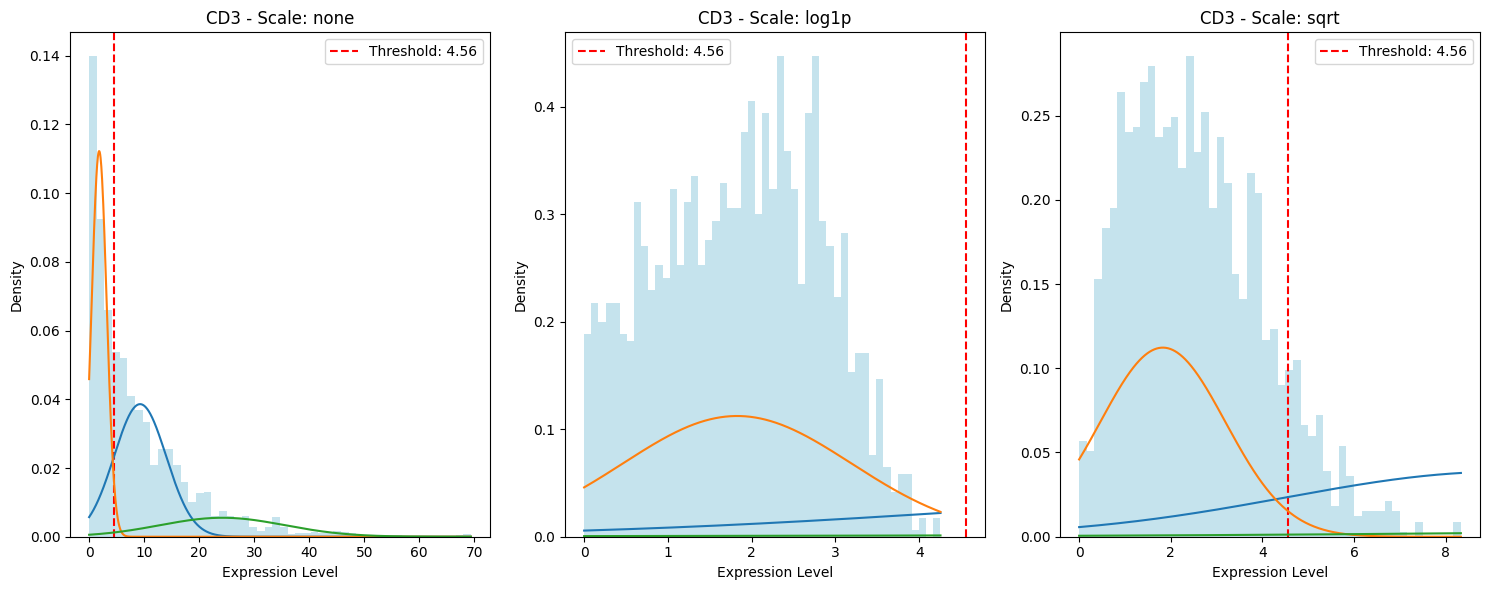

INFO:thresholdpy.thresholdpy:Using 'feature_types' column to identify protein features


Generated distribution plot for CD4


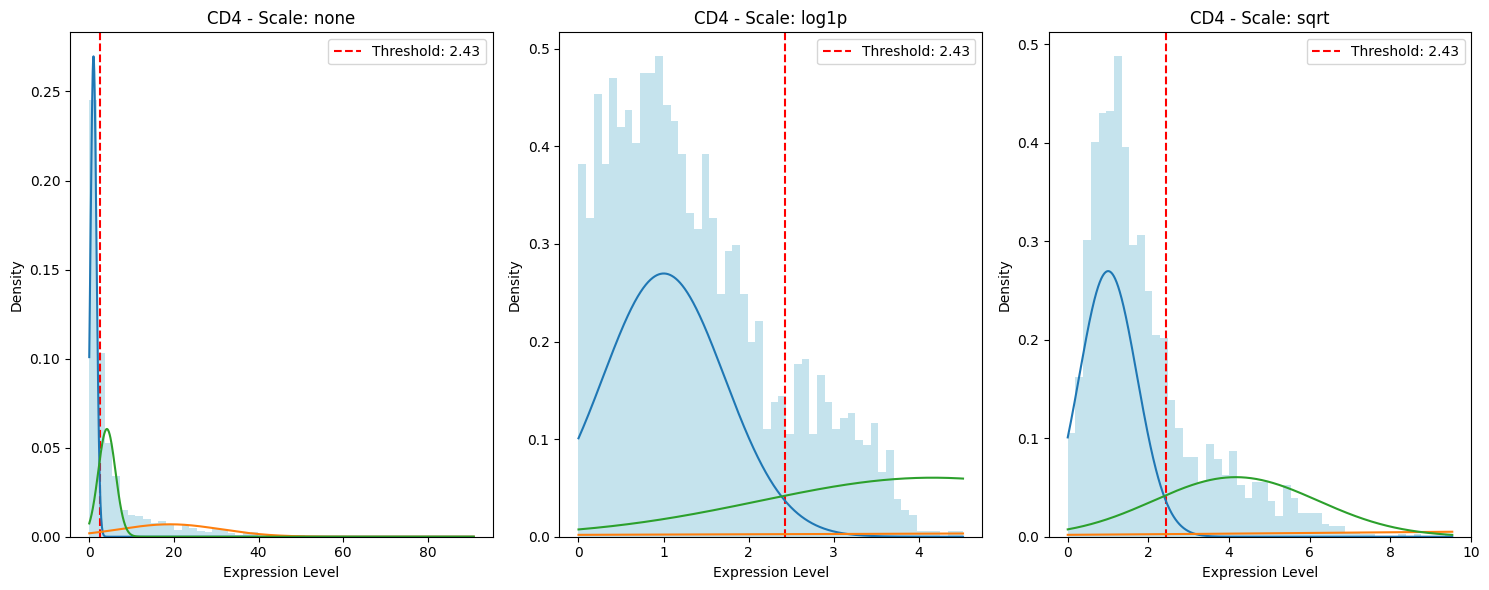

INFO:thresholdpy.thresholdpy:Using 'feature_types' column to identify protein features


Generated distribution plot for CD19


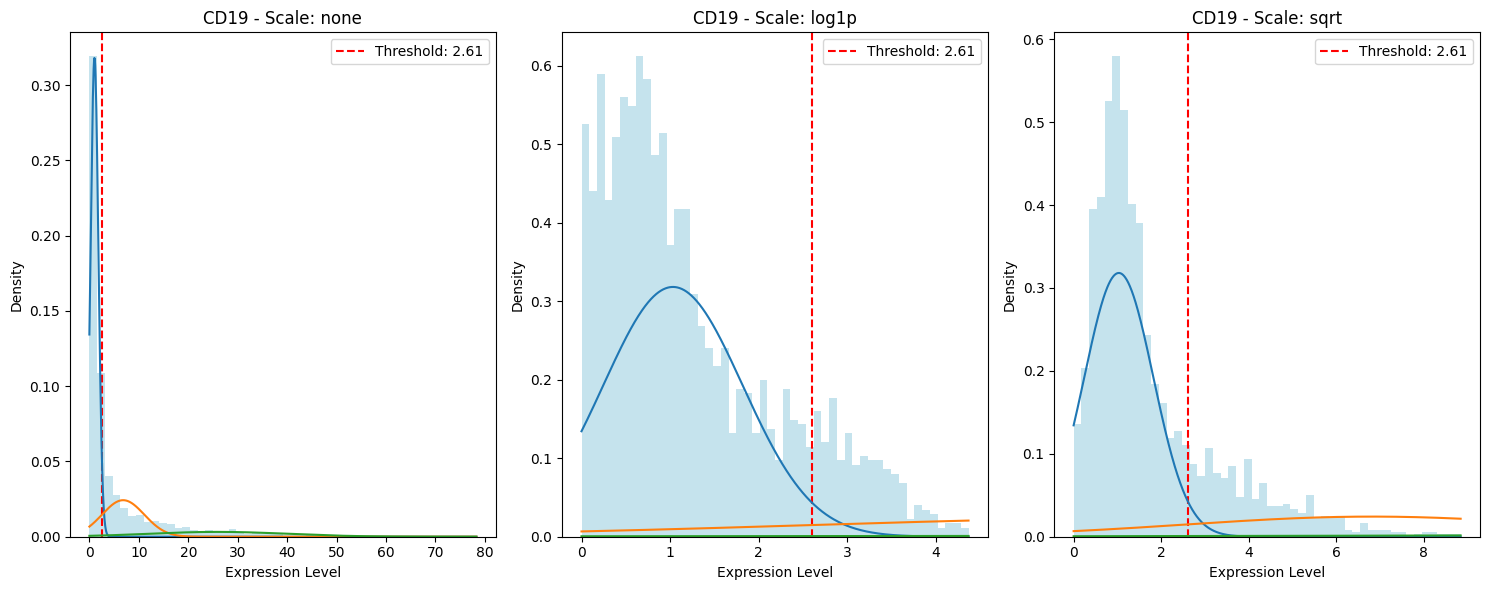

In [10]:
print("\n" + "="*50)
print("VISUALIZATION EXAMPLE")
print("="*50)

# Plot distributions for a few proteins
proteins_to_plot = ['CD3', 'CD4', 'CD19']

for i, protein in enumerate(proteins_to_plot):
    if protein in model_adv.thresholds_:
        # Use ThresholdPy's built-in plotting
        protein_fig = model_adv.plot_protein_distribution(
            protein, adata_adv, protein_layer='protein_raw', scales=['none', 'log1p', 'sqrt'])
        
        print(f"Generated distribution plot for {protein}")
        plt.show()  # Show individual plots
    else:
        print(f"Protein {protein} not found in fitted models")

plt.show()

## Demonstrate quality control and comparison analysis


QUALITY CONTROL EXAMPLE

1. Basic statistics comparison:
Original data sparsity: 2.2%
Denoised data sparsity: 74.4%
Sparsity increase: 72.3 percentage points

Total counts - Original: 44006
Total counts - Denoised: 32391
Counts retained: 73.6%

2. Per-protein analysis:
  protein  cells_retained_pct  mean_retained_pct
0     CD3                35.3               75.1
1     CD4                31.7               86.6
2     CD8                29.5               76.0
3    CD19                28.8               83.0
4    CD14                34.6               89.2
5    CD16                20.0               79.2
6    CD56                19.8               70.5
7    CD45                19.1               49.7
8    CD25                18.7               51.5
9   CD127                23.7               77.3


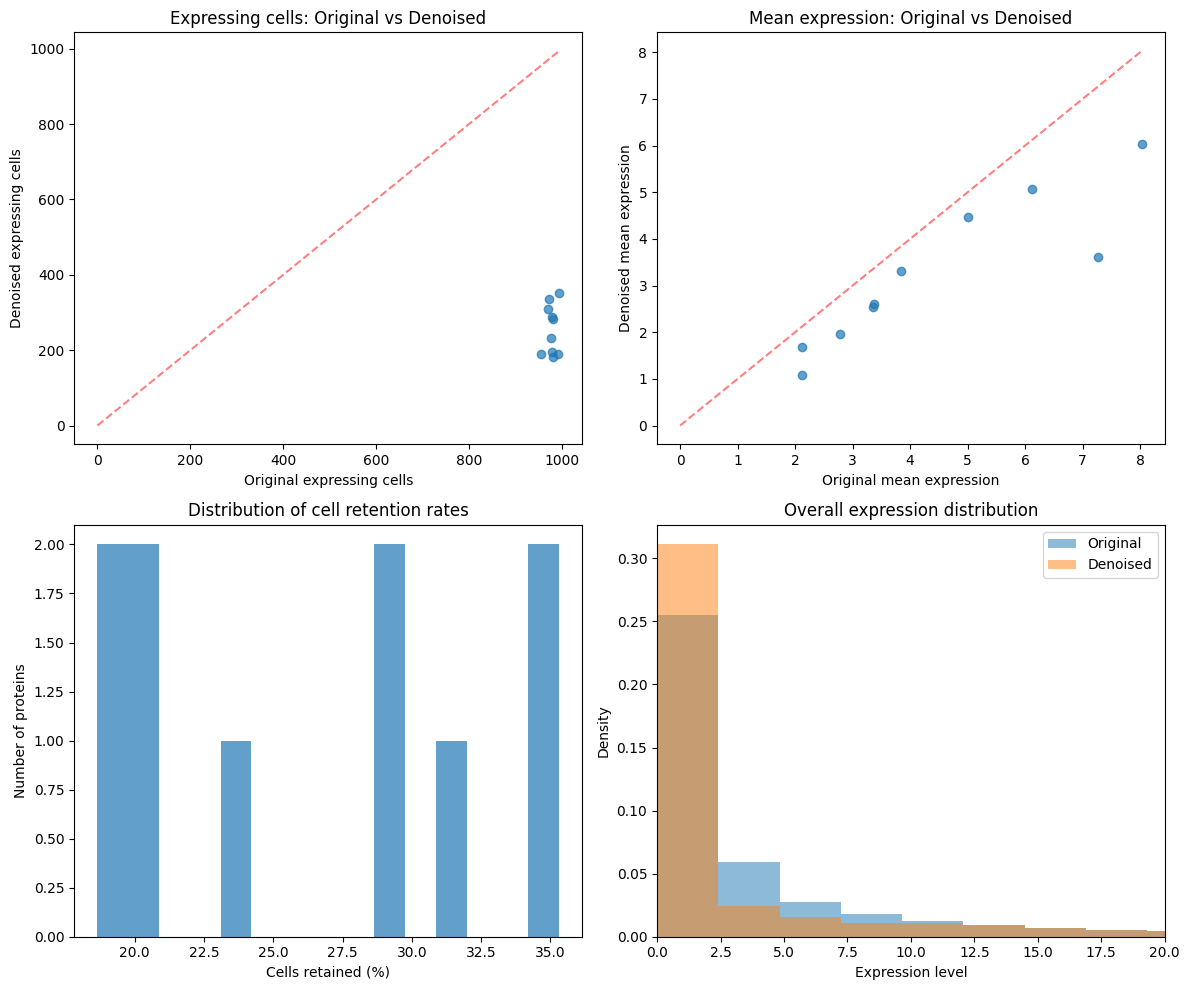

,protein,orig_expressing_cells,denoised_expressing_cells,cells_retained_pct,orig_mean,denoised_mean,mean_retained_pct
0,CD3,994,351,35.311871,8.027141,6.029027,75.108014
1,CD4,971,308,31.719876,3.837901,3.321842,86.553605
2,CD8,979,289,29.519918,3.354077,2.549614,76.015372
3,CD19,982,283,28.818737,6.116353,5.076446,82.997917
4,CD14,973,337,34.635149,5.007539,4.465267,89.170885
5,CD16,955,191,20.000000,2.115114,1.674229,79.155496
6,CD56,979,194,19.816139,2.782941,1.961642,70.488104
7,CD45,992,189,19.052419,7.271010,3.610673,49.658474
8,CD25,981,183,18.654434,2.113479,1.087488,51.454897
9,CD127,977,232,23.746162,3.380116,2.614422,77.347120


In [6]:
print("\n" + "="*50)
print("QUALITY CONTROL EXAMPLE")
print("="*50)

# Get original and denoised data
original_data = adata.layers['protein_raw']
denoised_data = adata.layers['protein_denoised']

# Calculate basic statistics
print("\n1. Basic statistics comparison:")

# Sparsity analysis
original_sparsity = np.mean(original_data == 0) * 100
denoised_sparsity = np.mean(denoised_data == 0) * 100

print(f"Original data sparsity: {original_sparsity:.1f}%")
print(f"Denoised data sparsity: {denoised_sparsity:.1f}%")
print(f"Sparsity increase: {denoised_sparsity - original_sparsity:.1f} percentage points")

# Count statistics
original_total = np.sum(original_data)
denoised_total = np.sum(denoised_data)

print(f"\nTotal counts - Original: {original_total:.0f}")
print(f"Total counts - Denoised: {denoised_total:.0f}")
print(f"Counts retained: {denoised_total/original_total*100:.1f}%")

# Per-protein analysis
print("\n2. Per-protein analysis:")
protein_stats = []

for i, protein in enumerate(adata.var_names):
    orig_nonzero = np.sum(original_data[:, i] > 0)
    denoised_nonzero = np.sum(denoised_data[:, i] > 0)
    
    orig_mean = np.mean(original_data[:, i])
    denoised_mean = np.mean(denoised_data[:, i])
    
    protein_stats.append({
        'protein': protein,
        'orig_expressing_cells': orig_nonzero,
        'denoised_expressing_cells': denoised_nonzero,
        'cells_retained_pct': denoised_nonzero/orig_nonzero*100 if orig_nonzero > 0 else 0,
        'orig_mean': orig_mean,
        'denoised_mean': denoised_mean,
        'mean_retained_pct': denoised_mean/orig_mean*100 if orig_mean > 0 else 0
    })

stats_df = pd.DataFrame(protein_stats)
print(stats_df[['protein', 'cells_retained_pct', 'mean_retained_pct']].round(1))

# Visualization of QC metrics
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Cells expressing each protein
axes[0, 0].scatter(stats_df['orig_expressing_cells'], 
                    stats_df['denoised_expressing_cells'], alpha=0.7)
axes[0, 0].plot([0, stats_df['orig_expressing_cells'].max()], 
                [0, stats_df['orig_expressing_cells'].max()], 'r--', alpha=0.5)
axes[0, 0].set_xlabel('Original expressing cells')
axes[0, 0].set_ylabel('Denoised expressing cells')
axes[0, 0].set_title('Expressing cells: Original vs Denoised')

# Plot 2: Mean expression
axes[0, 1].scatter(stats_df['orig_mean'], stats_df['denoised_mean'], alpha=0.7)
axes[0, 1].plot([0, stats_df['orig_mean'].max()], 
                [0, stats_df['orig_mean'].max()], 'r--', alpha=0.5)
axes[0, 1].set_xlabel('Original mean expression')
axes[0, 1].set_ylabel('Denoised mean expression')
axes[0, 1].set_title('Mean expression: Original vs Denoised')

# Plot 3: Retention percentages
axes[1, 0].hist(stats_df['cells_retained_pct'], bins=15, alpha=0.7)
axes[1, 0].set_xlabel('Cells retained (%)')
axes[1, 0].set_ylabel('Number of proteins')
axes[1, 0].set_title('Distribution of cell retention rates')

# Plot 4: Overall distribution comparison
sample_cells = np.random.choice(adata.n_obs, 1000, replace=False)
orig_sample = original_data[sample_cells, :].flatten()
denoised_sample = denoised_data[sample_cells, :].flatten()

axes[1, 1].hist(orig_sample, bins=50, alpha=0.5, label='Original', density=True)
axes[1, 1].hist(denoised_sample, bins=50, alpha=0.5, label='Denoised', density=True)
axes[1, 1].set_xlabel('Expression level')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Overall expression distribution')
axes[1, 1].legend()
axes[1, 1].set_xlim(0, 20)  # Focus on lower range

plt.tight_layout()
plt.show()

display(stats_df)


## Demonstrate processing multiple samples

INFO:thresholdpy.thresholdpy:Starting ThresholdPy fitting...
INFO:thresholdpy.thresholdpy:Using 'feature_types' column to identify protein features
INFO:thresholdpy.thresholdpy:Fitting models for 10 of 10 proteins
INFO:thresholdpy.thresholdpy:Fitting GMM for CD3 (1/10)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD4 (2/10)



BATCH PROCESSING EXAMPLE
Creating multiple samples with different characteristics...
Creating synthetic CITE-seq data: 902 cells x 10 proteins
Data created successfully!
Mean counts per cell: 47.5
Mean proteins detected per cell: 5.9
  Sample_A: 902 cells
Creating synthetic CITE-seq data: 1124 cells x 10 proteins
Data created successfully!
Mean counts per cell: 44.0
Mean proteins detected per cell: 5.8
  Sample_B: 1124 cells
Creating synthetic CITE-seq data: 1076 cells x 10 proteins
Data created successfully!
Mean counts per cell: 48.6
Mean proteins detected per cell: 6.3
  Sample_C: 1076 cells

Processing samples with ThresholdPy...

Processing Sample_A...


INFO:thresholdpy.thresholdpy:Fitting GMM for CD8 (3/10)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD19 (4/10)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD14 (5/10)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD16 (6/10)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD56 (7/10)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD45 (8/10)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD25 (9/10)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD127 (10/10)
INFO:thresholdpy.thresholdpy:Completed fitting for 10 proteins
INFO:thresholdpy.thresholdpy:Using 'feature_types' column to identify protein features
INFO:thresholdpy.thresholdpy:Starting ThresholdPy fitting...
INFO:thresholdpy.thresholdpy:Using 'feature_types' column to identify protein features
INFO:thresholdpy.thresholdpy:Fitting models for 10 of 10 proteins
INFO:thresholdpy.thresholdpy:Fitting GMM for CD3 (1/10)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD4 (2/10)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD8 (3/10)
INFO:thresh

  Successfully fitted 10/10 proteins

Processing Sample_B...


INFO:thresholdpy.thresholdpy:Fitting GMM for CD25 (9/10)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD127 (10/10)
INFO:thresholdpy.thresholdpy:Completed fitting for 10 proteins
INFO:thresholdpy.thresholdpy:Using 'feature_types' column to identify protein features
INFO:thresholdpy.thresholdpy:Starting ThresholdPy fitting...
INFO:thresholdpy.thresholdpy:Using 'feature_types' column to identify protein features
INFO:thresholdpy.thresholdpy:Fitting models for 10 of 10 proteins
INFO:thresholdpy.thresholdpy:Fitting GMM for CD3 (1/10)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD4 (2/10)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD8 (3/10)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD19 (4/10)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD14 (5/10)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD16 (6/10)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD56 (7/10)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD45 (8/10)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD25 (9/10)
INFO:thres

  Successfully fitted 10/10 proteins

Processing Sample_C...
  Successfully fitted 10/10 proteins

3. Comparing thresholds across samples:
Threshold comparison across samples:
sample   Sample_A  Sample_B  Sample_C
protein                              
CD127        3.39      2.92      3.07
CD14         3.80      4.81      3.94
CD16         0.94      2.72      3.55
CD19         3.22      3.55      2.04
CD25         3.79      2.51      1.97
CD3         16.34     13.79      8.86
CD4          3.93      3.01      3.36
CD45        11.10      8.96     10.06
CD56         2.57      1.04      5.11
CD8          1.07      4.20      4.73

Coefficient of variation in thresholds:
  CD127: 0.077
  CD14: 0.131
  CD16: 0.555
  CD19: 0.271
  CD25: 0.339
  CD3: 0.292
  CD4: 0.134
  CD45: 0.107
  CD56: 0.707
  CD8: 0.594


C:\Users\jones\AppData\Local\Temp\ipykernel_2936\1514266409.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


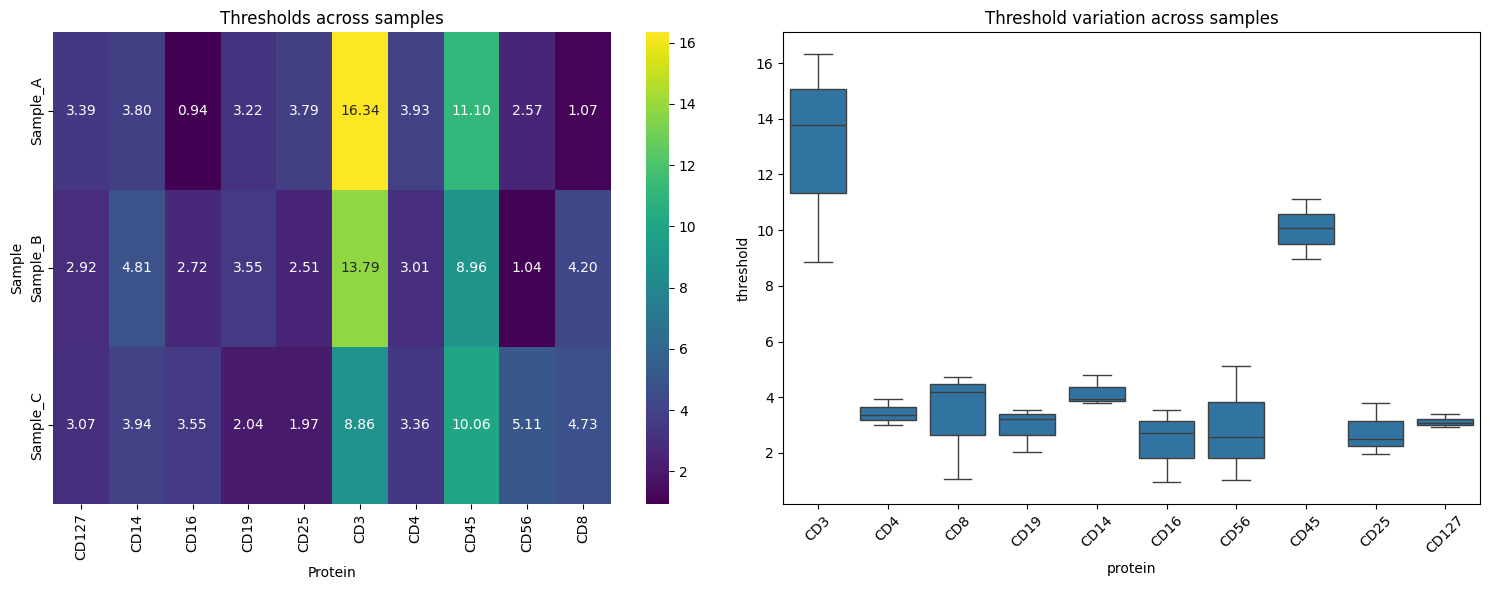

{'Sample_A': AnnData object with n_obs × n_vars = 902 × 10
     obs: 'total_protein_counts', 'n_proteins_detected'
     var: 'feature_types'
     layers: 'protein_raw', 'protein_denoised',
 'Sample_B': AnnData object with n_obs × n_vars = 1124 × 10
     obs: 'total_protein_counts', 'n_proteins_detected'
     var: 'feature_types'
     layers: 'protein_raw', 'protein_denoised',
 'Sample_C': AnnData object with n_obs × n_vars = 1076 × 10
     obs: 'total_protein_counts', 'n_proteins_detected'
     var: 'feature_types'
     layers: 'protein_raw', 'protein_denoised'}

{'Sample_A': <thresholdpy.thresholdpy.ThresholdPy at 0x187b9172610>,
 'Sample_B': <thresholdpy.thresholdpy.ThresholdPy at 0x187b8ec9bd0>,
 'Sample_C': <thresholdpy.thresholdpy.ThresholdPy at 0x187afe76450>}

,protein,threshold,sample
0,CD3,16.336373,Sample_A
1,CD4,3.926435,Sample_A
2,CD8,1.065055,Sample_A
3,CD19,3.224027,Sample_A
4,CD14,3.795684,Sample_A
5,CD16,0.939598,Sample_A
6,CD56,2.567038,Sample_A
7,CD45,11.103103,Sample_A
8,CD25,3.793569,Sample_A
9,CD127,3.391177,Sample_A


In [7]:
print("\n" + "="*50)
print("BATCH PROCESSING EXAMPLE")
print("="*50)

# Simulate multiple samples with slightly different characteristics
samples = {}
sample_names = ['Sample_A', 'Sample_B', 'Sample_C']

print("Creating multiple samples with different characteristics...")

for i, sample_name in enumerate(sample_names):
    # Vary parameters slightly between samples
    np.random.seed(42 + i)  # Different seed for each sample
    n_cells = np.random.randint(800, 1200)  # Variable sample size
    
    adata = create_realistic_citeseq_data(n_cells=n_cells, n_proteins=10)
    
    # Add some sample-specific variation
    # Simulate batch effects
    batch_effect = np.random.normal(0, 0.2, adata.n_vars)
    adata.X *= (1 + batch_effect)
    adata.layers['protein_raw'] = adata.X.copy()
    
    samples[sample_name] = adata
    print(f"  {sample_name}: {n_cells} cells")

# Process each sample
print("\nProcessing samples with ThresholdPy...")
threshold_models = {}

for sample_name, adata in samples.items():
    print(f"\nProcessing {sample_name}...")
    
    # Apply ThresholdPy
    model = ThresholdPy(random_state=42)  # Same random state for consistency
    model.fit_transform(adata, protein_layer='protein_raw')
    
    threshold_models[sample_name] = model
    
    # Print summary for this sample
    summary = model.get_threshold_summary()
    converged_count = summary['converged'].sum()
    print(f"  Successfully fitted {converged_count}/{len(summary)} proteins")

# Compare thresholds across samples
print("\n3. Comparing thresholds across samples:")

all_thresholds = []
for sample_name, model in threshold_models.items():
    summary = model.get_threshold_summary()
    summary['sample'] = sample_name
    all_thresholds.append(summary[['protein', 'threshold', 'sample']])

combined_thresholds = pd.concat(all_thresholds)

# Pivot table for easy comparison
threshold_comparison = combined_thresholds.pivot(
    index='protein', columns='sample', values='threshold'
)

print("Threshold comparison across samples:")
print(threshold_comparison.round(2))

# Calculate coefficient of variation for each protein
threshold_cv = threshold_comparison.std(axis=1) / threshold_comparison.mean(axis=1)
print(f"\nCoefficient of variation in thresholds:")
for protein, cv in threshold_cv.items():
    print(f"  {protein}: {cv:.3f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Heatmap of thresholds
sns.heatmap(threshold_comparison.T, annot=True, fmt='.2f', 
            cmap='viridis', ax=axes[0])
axes[0].set_title('Thresholds across samples')
axes[0].set_xlabel('Protein')
axes[0].set_ylabel('Sample')

# Box plot of threshold variation
melted_thresholds = combined_thresholds.dropna()
sns.boxplot(data=melted_thresholds, x='protein', y='threshold', ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].set_title('Threshold variation across samples')

plt.tight_layout()
plt.show()

display(samples, threshold_models, combined_thresholds)


## Demonstrate integration with standard scanpy workflow


SCANPY INTEGRATION EXAMPLE
Creating combined RNA + Protein dataset...
Creating synthetic CITE-seq data: 1500 cells x 15 proteins
Data created successfully!
Mean counts per cell: 59.3
Mean proteins detected per cell: 8.6


C:\Users\jones\AppData\Local\Temp\ipykernel_2936\4067663431.py:59: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  adata_combined = ad.concat([adata_rna, adata_protein], axis = "var", join = "outer", label = "modality", merge = "unique", uns_merge = "unique")
INFO:thresholdpy.thresholdpy:Starting ThresholdPy fitting...
INFO:thresholdpy.thresholdpy:Using 'feature_types' column to identify protein features
INFO:thresholdpy.thresholdpy:Fitting models for 15 of 15 proteins
INFO:thresholdpy.thresholdpy:Fitting GMM for CD3 (1/15)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD4 (2/15)


RNA data: (1500, 2000)
Protein data: (1500, 15)

1. Processing RNA data with standard scanpy workflow:
After filtering: (1500, 630)

2. Processing protein data with ThresholdPy:


INFO:thresholdpy.thresholdpy:Fitting GMM for CD8 (3/15)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD19 (4/15)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD14 (5/15)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD16 (6/15)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD56 (7/15)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD45 (8/15)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD25 (9/15)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD127 (10/15)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD62L (11/15)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD44 (12/15)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD95 (13/15)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD45RO (14/15)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD45RA (15/15)
INFO:thresholdpy.thresholdpy:Completed fitting for 15 proteins
INFO:thresholdpy.thresholdpy:Using 'feature_types' column to identify protein features


Successfully processed 15/15 proteins

3. Combining RNA and protein data for joint analysis:
Common cells: 1500
Combined data structure:
  RNA genes: 630
  Protein matrices in .obsm: ['protein_raw', 'protein_denoised']
  Proteins: 15

4. Continuing with standard scanpy analysis:


c:\Anaconda3\envs\scseq-rdj\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\jones\AppData\Local\Temp\ipykernel_2936\4067663431.py:109: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_combined2, resolution=0.3)


Identified 1 clusters

5. Analyzing protein expression by cluster:
Mean protein expression by cluster:
            CD3   CD4  CD8  CD19  CD14  CD16  CD56  CD45  CD25  CD127  CD62L  \
Cluster_0  7.62  2.84  2.0  2.27  2.75  2.81  2.04  7.51  0.66   1.62   1.94   

           CD44  CD95  CD45RO  CD45RA  
Cluster_0  2.67  1.05    1.23    1.71  


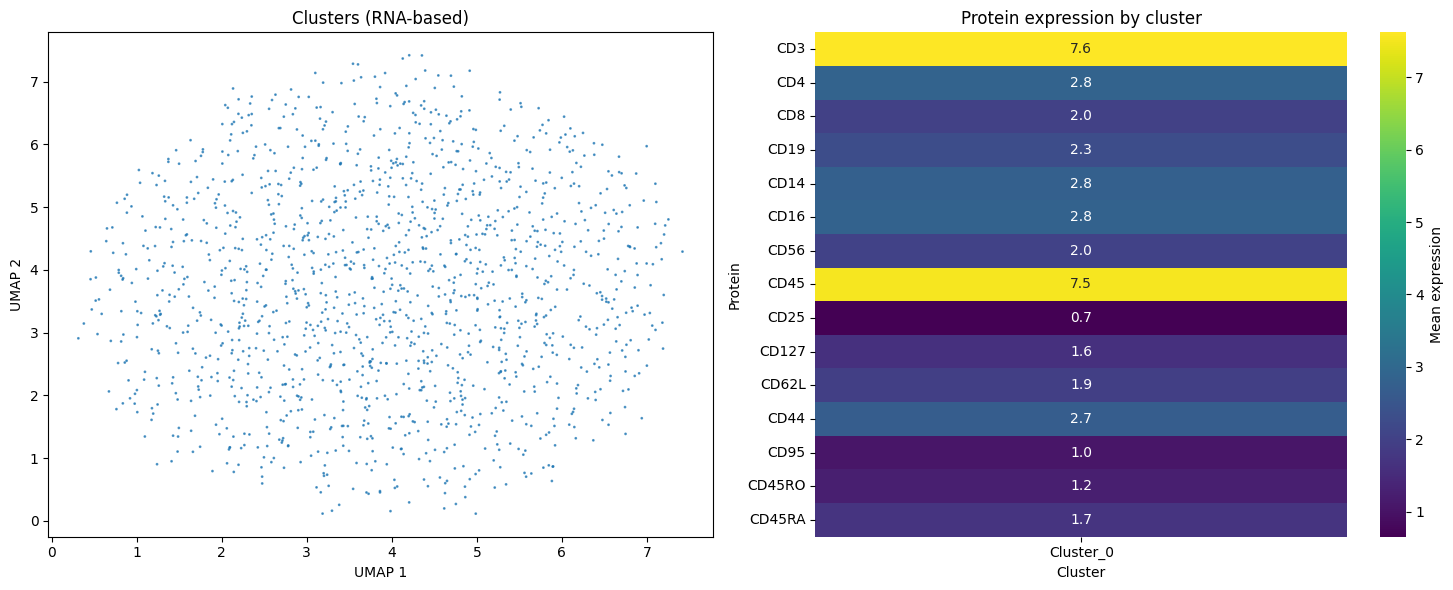

AnnData object with n_obs × n_vars = 1500 × 645
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_protein_counts', 'n_proteins_detected'
    var: 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'modality'
    uns: 'log1p', 'hvg', 'threshold_model'
    layers: 'protein_raw', 'protein_denoised'

AnnData object with n_obs × n_vars = 1500 × 630
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'leiden'
    var: 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'protein_names', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'protein_raw', 'protein_denoised', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [8]:
print("\n" + "="*50)
print("SCANPY INTEGRATION EXAMPLE")
print("="*50)

# Create data that simulates RNA + protein
print("Creating combined RNA + Protein dataset...")

# Create protein data
adata_protein = create_realistic_citeseq_data(n_cells=1500, n_proteins=15)

# Create mock RNA data (much larger feature space)
n_genes = 2000
rna_data = np.random.negative_binomial(2, 0.1, (adata_protein.n_obs, n_genes))

# Add some structure to RNA data
for i in range(n_genes):
    # Some genes are highly expressed in subsets of cells
    if i % 100 == 0:  # Every 100th gene
        expressing_cells = np.random.choice(
            adata_protein.n_obs, adata_protein.n_obs//5, replace=False
        )
        rna_data[expressing_cells, i] += np.random.negative_binomial(10, 0.3, len(expressing_cells))

# Create RNA AnnData
adata_rna = AnnData(rna_data.astype(float))
adata_rna.var_names = [f'Gene_{i:04d}' for i in range(n_genes)]
adata_rna.obs_names = adata_protein.obs_names.copy()
adata_rna.var['feature_types'] = 'Gene'

print(f"RNA data: {adata_rna.shape}")
print(f"Protein data: {adata_protein.shape}")

# Standard scanpy preprocessing for RNA
print("\n1. Processing RNA data with standard scanpy workflow:")

# Basic filtering
sc.pp.filter_cells(adata_rna, min_genes=200)
sc.pp.filter_genes(adata_rna, min_cells=3)

# Calculate QC metrics
adata_rna.var['mt'] = adata_rna.var_names.str.startswith('Gene_00')  # Mock MT genes
sc.pp.calculate_qc_metrics(adata_rna, percent_top=None, log1p=False, inplace=True)

# Normalization and log transformation
sc.pp.normalize_total(adata_rna, target_sum=1e4)
sc.pp.log1p(adata_rna)

# Feature selection
sc.pp.highly_variable_genes(adata_rna, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata_rna.raw = adata_rna
adata_rna = adata_rna[:, adata_rna.var.highly_variable]

print(f"After filtering: {adata_rna.shape}")

# Process protein data with ThresholdPy
print("\n2. Processing protein data with ThresholdPy:")
# Combine RNA and protein data

adata_combined = ad.concat([adata_rna, adata_protein], axis = "var", join = "outer", label = "modality", merge = "unique", uns_merge = "unique")
pp_threshold_proteins(
    adata_combined, #adata_protein, 
    protein_layer='protein_raw',
    output_layer='protein_denoised',
    inplace=True
)

# Get threshold model
# threshold_model = adata_protein.uns['threshold_model']
threshold_model = adata_combined.uns['threshold_model']
summary = threshold_model.get_threshold_summary()
successful_proteins = summary[summary['converged']].shape[0]
print(f"Successfully processed {successful_proteins}/{len(summary)} proteins")

# Create combined analysis
print("\n3. Combining RNA and protein data for joint analysis:")

# Match cells (in case filtering removed some)
common_cells = adata_rna.obs_names.intersection(adata_protein.obs_names)
adata_rna_matched = adata_rna[common_cells, :].copy()
adata_protein_matched = adata_protein[common_cells, :].copy()
adata_combined_matched = adata_combined[common_cells, :].copy()

print(f"Common cells: {len(common_cells)}")

# Option 1: Store protein data in RNA object
adata_combined2 = adata_rna_matched.copy()
adata_combined2.obsm['protein_raw'] = adata_protein_matched.layers['protein_raw']
adata_combined2.obsm['protein_denoised'] = adata_combined_matched.layers['protein_denoised']

# Add protein names to uns
adata_combined2.uns['protein_names'] = adata_protein.var_names.tolist()

print("Combined data structure:")
print(f"  RNA genes: {adata_rna.n_vars}")
print(f"  Protein matrices in .obsm: {list(adata_combined2.obsm.keys())}")
print(f"  Proteins: {len(adata_combined2.uns['protein_names'])}")

# Proceed with standard scanpy analysis on RNA
print("\n4. Continuing with standard scanpy analysis:")

# PCA on RNA
sc.tl.pca(adata_combined2, svd_solver='arpack')

# Neighbors and UMAP
sc.pp.neighbors(adata_combined2, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_combined2)

# Clustering
sc.tl.leiden(adata_combined2, resolution=0.3)

print(f"Identified {len(adata_combined2.obs['leiden'].unique())} clusters")

# Analyze protein expression by cluster
print("\n5. Analyzing protein expression by cluster:")

protein_denoised = adata_combined2.obsm['protein_denoised']
protein_mask = ~np.all(np.isnan(protein_denoised), axis=0)
clusters = adata_combined2.obs['leiden']

cluster_protein_means = []
for cluster in clusters.unique():
    cluster_mask = clusters == cluster
    cluster_mean = np.mean(protein_denoised[np.ix_(cluster_mask, protein_mask)], axis=0)
    cluster_protein_means.append(cluster_mean)

cluster_protein_df = pd.DataFrame(
    cluster_protein_means,
    index=[f'Cluster_{c}' for c in clusters.unique()],
    columns=adata_combined2.uns['protein_names']
)

print("Mean protein expression by cluster:")
print(cluster_protein_df.round(2))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# UMAP colored by clusters
scatter = axes[0].scatter(
    adata_combined2.obsm['X_umap'][:, 0], 
    adata_combined2.obsm['X_umap'][:, 1],
    c=clusters.astype('category').cat.codes, 
    cmap='tab10', s=1, alpha=0.7
)
axes[0].set_xlabel('UMAP 1')
axes[0].set_ylabel('UMAP 2')
axes[0].set_title('Clusters (RNA-based)')

# Protein expression heatmap
sns.heatmap(cluster_protein_df.T, annot=True, fmt='.1f', 
            cmap='viridis', ax=axes[1], cbar_kws={'label': 'Mean expression'})
axes[1].set_title('Protein expression by cluster')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Protein')

plt.tight_layout()
plt.show()

display(adata_combined, adata_combined2, threshold_model)


## Demonstrate integration with MuData for multi-modal single-cell analysis


MUDATA INTEGRATION EXAMPLE
Creating multi-modal dataset with RNA and Protein data...
Creating synthetic CITE-seq data: 1500 cells x 15 proteins
Data created successfully!
Mean counts per cell: 55.0
Mean proteins detected per cell: 8.2


c:\Anaconda3\envs\scseq-rdj\Lib\site-packages\mudata\_core\mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
c:\Anaconda3\envs\scseq-rdj\Lib\site-packages\mudata\_core\mudata.py:1461: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)
INFO:thresholdpy.thresholdpy:Starting ThresholdPy fitting...
INFO:thresholdpy.thresholdpy:Using protein modality: prot
INFO:thresholdpy.threshol

Creating MuData object with RNA and Protein modalities...

Running ThresholdPy on protein data...


INFO:thresholdpy.thresholdpy:Fitting GMM for CD45 (8/15)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD25 (9/15)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD127 (10/15)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD62L (11/15)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD44 (12/15)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD95 (13/15)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD45RO (14/15)
INFO:thresholdpy.thresholdpy:Fitting GMM for CD45RA (15/15)
INFO:thresholdpy.thresholdpy:Completed fitting for 15 proteins
INFO:thresholdpy.thresholdpy:Using protein modality: prot
INFO:thresholdpy.thresholdpy:Using 'feature_types' column to identify protein features
INFO:thresholdpy.thresholdpy:Writing to protein modality: prot



Protein threshold summary:
  protein  threshold  converged  n_valid_cells          aic          bic  \
0     CD3  11.231798       True           1500  9947.072215  9973.638317   
1     CD4   3.924561       True           1500  7557.724387  7584.290489   
2     CD8   3.642437       True           1500  7219.859855  7246.425957   
3    CD19   1.843783       True           1500  6183.002458  6209.568560   
4    CD14   4.162962       True           1500  7073.396466  7099.962568   

   log_likelihood  
0       -3.312357  
1       -2.515908  
2       -2.403287  
3       -2.057667  
4       -2.354465  

Plotting distribution for CD3...


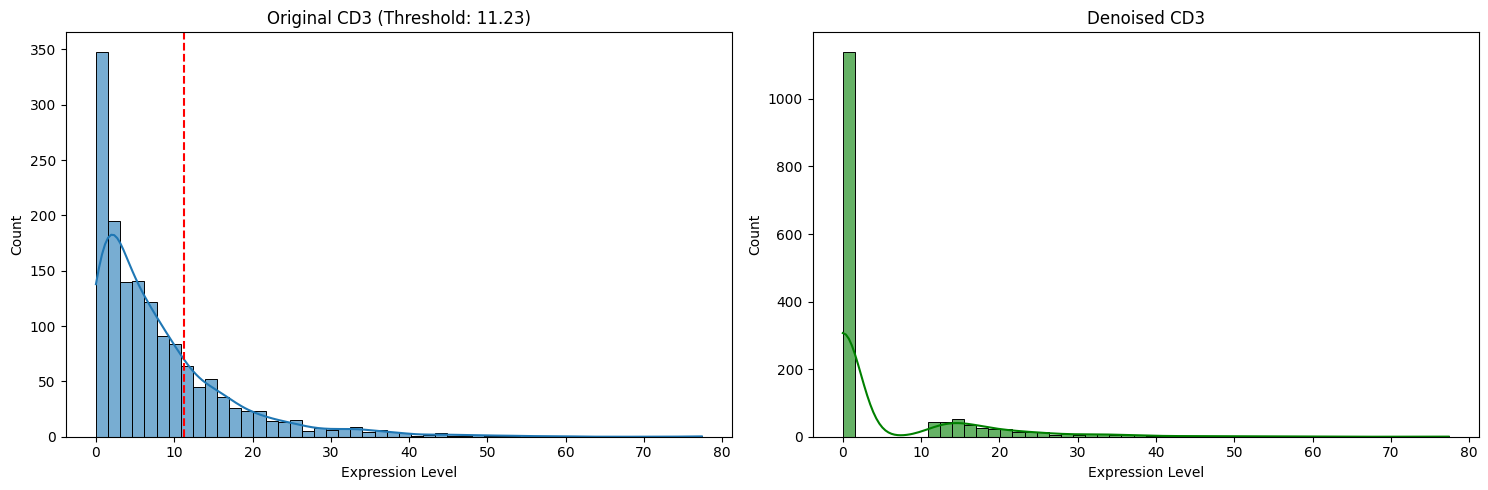


Continuing with standard scanpy workflow on the MuData object...


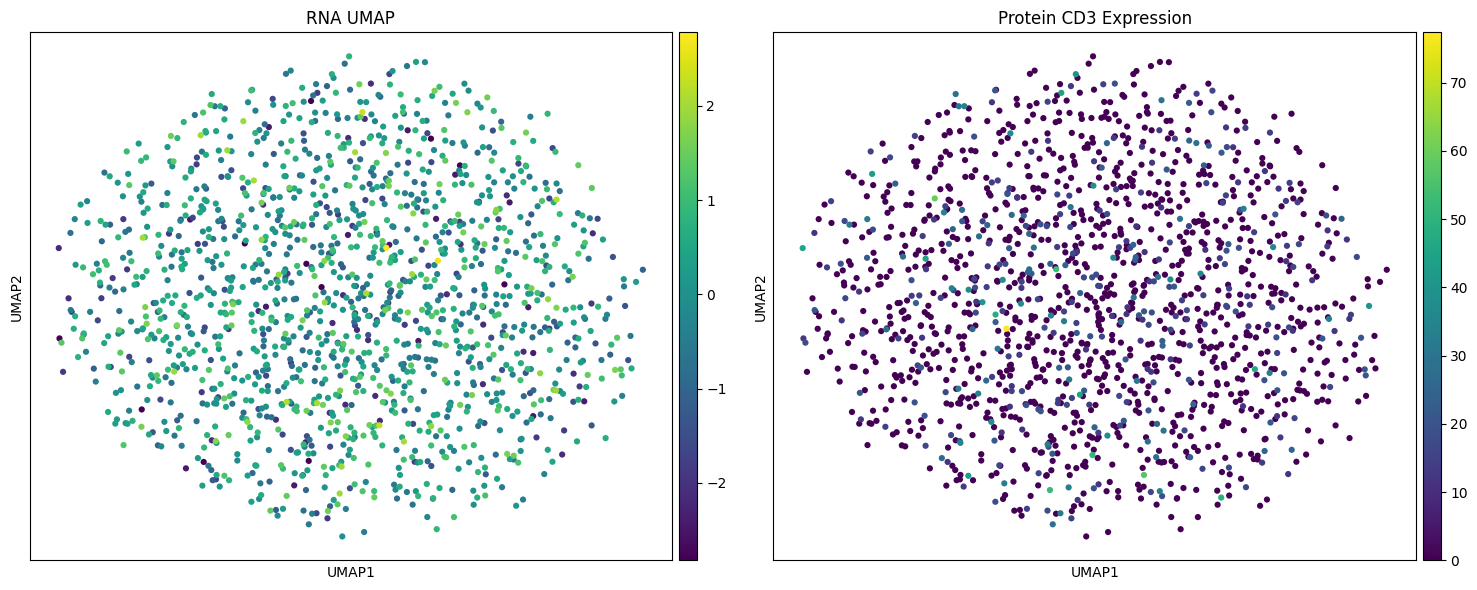


MuData integration example completed!


MuData object with n_obs × n_vars = 1500 × 2015
  2 modalities
    rna:	1500 x 2000
      obs:	'CD3', 'CD4', 'CD8', 'CD19', 'CD14', 'CD16', 'CD56', 'CD45', 'CD25', 'CD127', 'CD62L', 'CD44', 'CD95', 'CD45RO', 'CD45RA'
      var:	'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'log1p', 'hvg', 'pca', 'neighbors', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'distances', 'connectivities'
    prot:	1500 x 15
      obs:	'total_protein_counts', 'n_proteins_detected'
      var:	'feature_types'
      layers:	'protein_raw', 'protein_denoised'

In [9]:
# Running this section assumes that the user has mudata installed

print("\n" + "="*50)
print("MUDATA INTEGRATION EXAMPLE")
print("="*50)

# Create protein data
print("Creating multi-modal dataset with RNA and Protein data...")
adata_protein = create_realistic_citeseq_data(n_cells=1500, n_proteins=15)

# Create mock RNA data (larger feature space)
n_genes = 2000
rna_data = np.random.negative_binomial(2, 0.1, (adata_protein.n_obs, n_genes))

# Add some structure to RNA data
for i in range(n_genes):
    # Some genes are highly expressed in subsets of cells
    if i % 100 == 0:  # Every 100th gene
        expressing_cells = np.random.choice(
            [True, False], 
            size=adata_protein.n_obs, 
            p=[0.3, 0.7]
        )
        rna_data[expressing_cells, i] += np.random.poisson(10, np.sum(expressing_cells))

# Create RNA AnnData
adata_rna = AnnData(rna_data)
adata_rna.var_names = [f'Gene_{i:04d}' for i in range(n_genes)]
adata_rna.obs_names = adata_protein.obs_names

# Create MuData object
print("Creating MuData object with RNA and Protein modalities...")
mudata = MuData({
    'rna': adata_rna,
    'prot': adata_protein
})

# Basic preprocessing for RNA data
sc.pp.filter_genes(mudata['rna'], min_cells=10)
sc.pp.normalize_total(mudata['rna'], target_sum=1e4)
sc.pp.log1p(mudata['rna'])
sc.pp.highly_variable_genes(mudata['rna'], min_mean=0.0125, max_mean=3, min_disp=0.5)

# Denoise protein data using ThresholdPy
print("\nRunning ThresholdPy on protein data...")
model_mudata = ThresholdPy()

# Option 1: Automatic modality detection (looks for 'prot' or 'protein' in modality names)
model_mudata.fit(mudata)

# Option 2: Explicitly specify the protein modality
# model.fit(mudata, protein_layer='prot')

# Transform in place (adds denoised data to the protein modality)
model_mudata.transform(mudata, inplace=True)

# Show some results
print("\nProtein threshold summary:")
print(model_mudata.get_threshold_summary().head())

# Visualize one protein
protein_to_plot = mudata['prot'].var_names[0]
print(f"\nPlotting distribution for {protein_to_plot}...")

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot original vs denoised data
original = mudata['prot'].layers['protein_raw'][:, 0].flatten()
denoised = mudata['prot'].layers['protein_denoised'][:, 0].flatten()

# Original data
sns.histplot(original, bins=50, kde=True, ax=axes[0], alpha=0.6)
axes[0].axvline(model_mudata.thresholds_[protein_to_plot], color='r', linestyle='--')
axes[0].set_title(f'Original {protein_to_plot} (Threshold: {model_mudata.thresholds_[protein_to_plot]:.2f})')
axes[0].set_xlabel('Expression Level')
axes[0].set_ylabel('Count')

# Denoised data
sns.histplot(denoised, bins=50, kde=True, ax=axes[1], color='green', alpha=0.6)
axes[1].set_title(f'Denoised {protein_to_plot}')
axes[1].set_xlabel('Expression Level')

plt.tight_layout()
plt.show()

# Continue with standard scanpy workflow on the MuData object
print("\nContinuing with standard scanpy workflow on the MuData object...")

# Example: Dimensionality reduction on RNA data
sc.pp.scale(mudata['rna'], max_value=10)
sc.tl.pca(mudata['rna'], svd_solver='arpack')
sc.pp.neighbors(mudata['rna'])
sc.tl.umap(mudata['rna'])

# Plot UMAP with protein expression
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# UMAP of RNA data
# sc.pl.umap(mudata['rna'], color='pca_loadings', show=False, ax=axes[0])
sc.pl.umap(mudata['rna'], color = mudata['rna'].var_names[0], show=False, ax=axes[0])#, color = 'X_pca
axes[0].set_title('RNA UMAP')

# UMAP with protein expression
# - First add protein data to RNA object's obs for plotting
prot_data = mudata['prot'].layers['protein_denoised']
for i, protein in enumerate(mudata['prot'].var_names):
    mudata['rna'].obs[protein] = prot_data[:, i].toarray().flatten() if hasattr(prot_data, 'toarray') else prot_data[:, i]
sc.pl.umap(mudata['rna'], color=protein_to_plot, layer='protein_denoised', 
            color_map='viridis', show=False, ax=axes[1])
axes[1].set_title(f'Protein {protein_to_plot} Expression')

plt.tight_layout()
plt.show()

print("\nMuData integration example completed!")

display(mudata, model_mudata)